In [18]:
import numpy as np
import cv2 as cv
import algos as alg
import write as wrt
import matplotlib.pyplot as plt

In [19]:
ivy = cv.imread("orig/poison-ivy.jpg")
oak_atln = cv.imread("orig/atlantic-poison-oak.jpg")
ivy2 = cv.imread("orig/poison-ivy2.jpg")
apple = cv.imread("orig/apple.png")
orange = cv.imread("orig/orange.jpg")
bear_oak = cv.imread("orig/bear_oak.jpg")
sumac = cv.imread("toxic_images/poison_sumac/361.jpg")
img1 = cv.imread("orig/Test_10.jpg", 1)
img2 = cv.imread("leaves/images/Test_0.jpg", 1)
img3 = cv.imread("leaves/images/Test_2.jpg", 1)

In [20]:
def gauss_kernel(ksize, s):
    return np.outer(cv.getGaussianKernel(ksize, s), cv.getGaussianKernel(ksize, s))


def gauss_filter(img, ksize, s):
    return cv.filter2D(img, -1, gauss_kernel(ksize, s))


def pyr_down(img, ksize=5, s=1.5):
    return gauss_filter(img, ksize, s)[::2, ::2]


def pyr_up(img, size=None, ksize=5, s=1.5):
    rows, cols = img.shape[:2]
    size = (cols * 2, rows * 2) if size is None else size
    dst = cv.resize(img, size, interpolation=cv.INTER_LINEAR)

    dst = cv.filter2D(dst, -1, gauss_kernel(ksize, s))

    return dst


def laplacianPyramid(gp):
    levels = len(gp) - 1
    lp = [gp[levels]]
    for i in range(levels, 0, -1):
        size = (gp[i - 1].shape[1], gp[i - 1].shape[0])
        GE = pyr_up(gp[i], size)
        L = gp[i - 1] - GE
        lp.append(L)
    return lp


def gaussianPyramid(img, num_levels, ks=25, s=1.5):
    lower = img.copy()
    gp = [np.float32(lower)]
    for _ in range(num_levels):
        lower = pyr_down(lower, ks, s)
        gp.append(np.float32(lower))
    return gp


In [21]:
def combine_images(outerImage, innerImage, mask, levels, ksize=25, s=1.5):
    gpCEye = gaussianPyramid(innerImage, levels, ksize, s)
    lpCEye = laplacianPyramid(gpCEye)
    gpFrame = gaussianPyramid(outerImage, levels, ksize, s)
    lpFrame = laplacianPyramid(gpFrame)
    gpMask = gaussianPyramid(mask, levels, ksize, s)
    gpMask.reverse()

    LS = []
    for lFrame, lCEye, gMask in zip(lpFrame, lpCEye, gpMask):
        lFrame[gMask == 255] = lCEye[gMask == 255]
        LS.append(lFrame)

    ls_ = LS[0]
    for i in range(1,levels+1):
        size = (LS[i].shape[1], LS[i].shape[0])
        ls_ = pyr_up(ls_, size)
        ls_ = ls_ + LS[i]

    ls_[ls_ < 0] = 0
    ls_[ls_ > 255] = 255
    return ls_.astype(np.uint8), lpFrame, lpCEye, gpMask

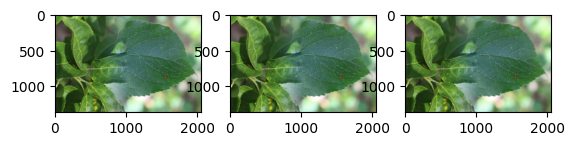

In [22]:
# img = apple
# aimg = cv.resize(orange,(apple.shape[1], apple.shape[0])) 
img = img1
aimg = img2
img_n = "apple"
mask = np.zeros_like(img)
# mask[:mask.shape[0]//4, :] = 255
mask[:, : mask.shape[1] // 2] = 255
# plt.imshow(mask, cmap="gray")
# plt.show()
# cv.imwrite(f"pyramid/{img_n}/mix/unh-7-mask-otsu1.png", mask)
wrt.test(
    img,
    [
        # lambda img: alg.switch_rgb(img),
        # lambda img: alg.switch_rgb(aimg),
        # lambda img: alg.switch_rgb(mask),
        lambda img: alg.switch_rgb(combine_images(img, aimg, mask, 7, 37)[0].astype(np.uint8)),
        lambda img: alg.switch_rgb(combine_images(img, aimg, mask, 7, 71)[0].astype(np.uint8)),
        lambda img: alg.switch_rgb(combine_images(img, aimg, mask, 7, 193)[0].astype(np.uint8)),
    ],
)
# list = combine_images(img, aimg, mask, 5)[1]

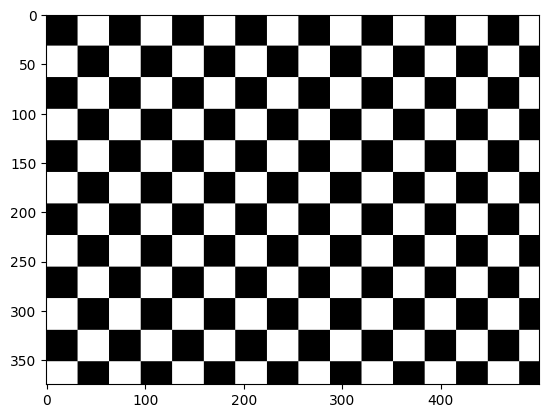

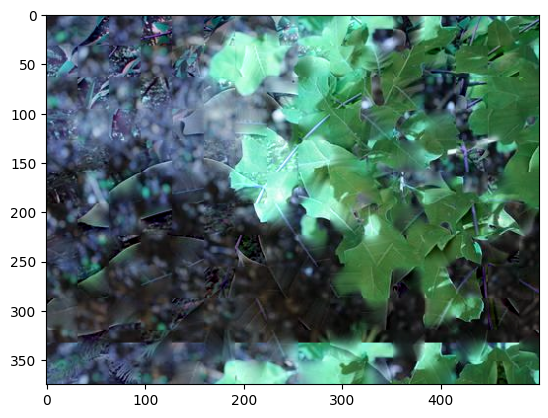

In [23]:
img = np.resize(bear_oak, (375, 500, 3))
aimg = sumac
img_n = "bear_oak"
mask = np.zeros_like(img)
#mask = alg.global_thresh(alg.to_gray(img), 30)
x_idx = np.arange(img.shape[1]) // 32
y_idx = np.arange(img.shape[0]) // 32
checkerboard = (x_idx + y_idx[:, np.newaxis]) % 2
mask = checkerboard.astype(np.uint8) * 255
#mask[:,:mask.shape[1]//2] = 255
plt.imshow(mask, cmap="gray")
# cv.imwrite(f"pyramid/{img_n}/mix/unh-7-mask-otsu1.png", mask)
plt.show()
plt.imshow(combine_images(img, aimg, mask, 7)[0])
#cv.imwrite(f"pyramid/{img_n}/mix/unh-7-otsu1.png", combine_images(img, aimg, mask, 7))
# cv.imwrite(f"pyramid/{img_n}/mix/unh-7.png", combine_images(img, aimg, mask, 7)[0])
mask[mask>1] = 1
# cv.imwrite(f"pyramid/{img_n}/mix/unh-7-basic-otsu1.png", cv.multiply(cv.merge((mask, mask, mask)), aimg) + cv.multiply(cv.merge(((1 - mask),(1 - mask),(1 - mask))), img))
#cv.imwrite(f"pyramid/{img_n}/mix/unh-7-basic.png", mask * aimg + (1 - mask) * img)

In [24]:
def pyramid_hist(p):
    fin = []
    for h in p:
        hist, _ = np.histogram(h.flatten(), 256, (0, 256))
        fin.append(hist)
    return fin


def app_pyramid_features(hists):
    return np.append(
        hists,
        [
            np.sum(
                np.nan_to_num(hist / np.sum(hist) * np.log2(hist / np.sum(hist) + 1e-6))
            )
            for hist in hists
        ],
    )


def glp_features(img, levels):
    gp = gaussianPyramid(img, levels)
    lp = laplacianPyramid(gp)
    return np.append(app_pyramid_features(pyramid_hist(gp)), app_pyramid_features(pyramid_hist(lp)))


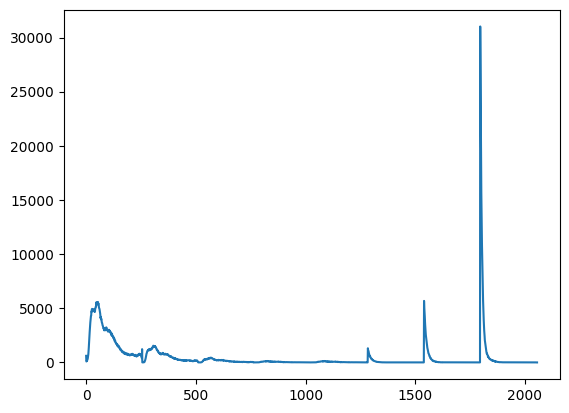

In [25]:
#print(np.max(glp_features(img, 3)))
plt.plot(glp_features(img, 3))

In [26]:
img_name = "leaf10"
img = img1
levels = 7
#alg.save_hist(img, f"{img_name}/{img_name}")
gp = gaussianPyramid(img, levels)

# Perform Laplacian pyramid decomposition
lp = laplacianPyramid(gp)

# Compute the histogram and entropy of the original image
hist, bins = np.histogram(img.flatten(), 256, [0,256])
entropy = -np.sum(np.nan_to_num(hist/np.sum(hist) * np.log2(hist/np.sum(hist)+1e-6)))

# Compute the histogram and entropy of the Gaussian pyramid
gauss_hist = []
for i in range(levels):
    hist, bins = np.histogram(gp[i].flatten(), 256, [0,256])
    gauss_hist.append(hist)
gauss_entropy = [np.sum(np.nan_to_num(hist/np.sum(hist) * np.log2(hist/np.sum(hist)+1e-6))) for hist in gauss_hist]

# Compute the histogram and entropy of the Laplacian pyramid
lap_hist = []
for i in range(levels):
    hist, bins = np.histogram(lp[i].flatten(), 256, [0,256])
    lap_hist.append(hist)
lap_entropy = [np.sum(np.nan_to_num(hist/np.sum(hist) * np.log2(hist/np.sum(hist)+1e-6))) for hist in lap_hist]
print("Original image entropy:", entropy)
print("Gaussian pyramid entropy:", gauss_entropy)
print("Laplacian pyramid entropy:", lap_entropy)
#ls_ = lp[0]
#for i in range(1,levels+1):
    #size = (lp[i].shape[1], lp[i].shape[0])
    #ls_ = pyr_up(ls_,size=size)
    #ls_ += lp[i]
#plt.imshow(alg.switch_rgb(ls_.astype(np.uint8)))

for i in range(levels):
    print(f"{i}")
    cv.imwrite(f"pyramid/{img_name}/gp{i}.png", gp[i].astype(np.uint8))
    #alg.save_hist(gp[i].astype(np.uint8), f"{img_name}/gp{i}")
    #fig, axs = plt.subplots(2)
    #axs[0].plot(gauss_hist[i])
    #axs[1].imshow(alg.switch_rgb(gp[i].astype(np.uint8)))
    plt.show()

cv.imwrite(f"pyramid/{img_name}/lp{0}.png", lp[0].astype(np.uint8))
#alg.save_hist(lp[0].astype(np.uint8), f"{img_name}/lp{0}")
for i in range(1, levels):
    print(f"{i}")
    cv.imwrite(f"pyramid/{img_name}/lp{i}.png", alg.to_gray(lp[i].astype(np.uint8)))
    #alg.save_hist(lp[i].astype(np.uint8), f"{img_name}/lp{i}")
    #fig, axs = plt.subplots(2)
    #axs[0].plot(lap_hist[i])
    #axs[1].imshow(lp[i].astype(np.uint8))
    plt.show()

Original image entropy: 7.48323798319531
Gaussian pyramid entropy: [-7.48323798319531, -7.4620559506622195, -7.435937393261208, -7.407000012648085, -7.3751196234962375, -7.299576177688264, -7.155703312711809]
Laplacian pyramid entropy: [-6.8660631713744085, -5.058777478178358, -4.595476537402145, -3.9997058233780636, -3.3983050075469907, -3.206396022176106, -2.989610747954689]
0
1
2
3
4
5
6
1
2
3
4
5
6


In [27]:
cv.imwrite("pyramid/leaf10/gp5-gp4.png", pyr_up(gp[5]).astype(np.uint8))

#for j in range(-1, levels):
    #ls_ = lp[0]
    #for i in range(1,levels-j):
        #size = (lp[i].shape[1], lp[i].shape[0])
        #ls_ = pyr_up(ls_,size=size)
        #ls_ += lp[i]
    #cv.imwrite(f"pyramid/leaf10/recn/lp_{i}.png", ls_.astype(np.uint8))
    ##plt.show()

True